# IAU Projekt 3. fáza

### Autori: Martin Raffáč (50%), Tibor Vanek (50%)

dataset číslo **003**

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, metrics
from pandas import read_csv
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot
import os
#import graphviz 
#import pydot
from IPython.display import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold

In [20]:
train_data = pd.read_csv("num_data.csv", sep=',')
test_data = pd.read_csv("test_data.csv", sep=',')

Náčítanie trénovacích dát.

In [21]:
data_for_oneR = train_data.copy()

## 1. Jednoduchý klasifikátor na základe závislosti v dátach 

In [22]:
def oneR(column):

    split = (data_for_oneR[column][data_for_oneR['warning'] == 0].mean() + data_for_oneR[column][data_for_oneR['warning'] == 1].mean())/2
    group = data_for_oneR[data_for_oneR[column] > split]
    group = group.groupby('warning').size()

    if group[0] > group[1]:
        left = 1
        right = 0
    else:
        left = 0
        right = 1
        
    predict = {"split": split, "left": left, "right": right}
    
    data_for_oneR.loc[data_for_oneR[column] < predict["split"], 'helper'] = predict["left"]
    data_for_oneR.loc[data_for_oneR[column] >= predict["split"], 'helper'] = predict["right"]
    accuracy = accuracy_score(data_for_oneR['warning'], data_for_oneR['helper'])
    precision = precision_score(data_for_oneR['warning'], data_for_oneR['helper'])
    recall = recall_score(data_for_oneR['warning'], data_for_oneR['helper'])
    total=(accuracy + precision + recall) / 3
    data_for_oneR.drop('helper', axis=1, inplace=True)

    return {"accuracy": accuracy, "precision": precision, "recall": recall ,"total": total}

In [23]:
accuracy = 0 
columns =  data_for_oneR.columns

for i in columns:
    if i == 'warning':
        continue

    data_oneR = oneR(i)
    
    if data_oneR["total"] > accuracy:
        best = i
        accuracy = data_oneR["total"]
        best_column = data_oneR
        
print('best oneR: ' + best)
print('total_score: ' + str(best_column["total"]))
print('accuracy_score: ' + str(best_column["accuracy"]))
print('precision_score: ' + str(best_column["precision"]))
print('recall_score: ' + str(best_column["recall"]))

best oneR: PAHs
total_score: 0.820169400418461
accuracy_score: 0.8000369503633452
precision_score: 0.855394280762565
recall_score: 0.8050769701294729


Podľa zadania sme zhotovili jednoduchý algoritmus oneR, ktorý sme vložili do funkcie. Následne sme ho vyskúšali na trénovacom datasete, predpokladali sme, že najlepší výsledok dosiahne atrihút PAHs, pretože má najvyššiu koreláciu s atribútom warning. Ako je možné vidieť vyššie naše predpoklady sa naplinili.  

## 2. Trénovanie a vyhodnotenie klasifikátorov strojového učenia

In [24]:
# treba trochu precistit dataset
train_data.drop(["Unnamed: 0"], axis= "columns", inplace = True)
test_data.drop(["Unnamed: 0", "station", "QoS", "code", "revision"], axis= "columns", inplace = True)

In [25]:
train_data.head()

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,latitude,NH3,H2CO,SO2,CH4,PM10,CFCs,NOx
0,100.48528,-0.988925,0.058518,0.472218,0.0,-1.036050,0.139994,-0.351726,1093.53327,1.608651,14.37395,-1.412422,0.500246,0.300432,-0.590449,-1.030510,1.690662,-0.301396
1,-0.36053,1.551800,-0.626781,-1.613285,1.0,1.520113,-0.790978,1.154782,1118.37192,1.740222,51.64316,0.946287,0.165570,-1.392993,-0.314318,1.626329,0.159929,0.465988
2,14.43865,0.319269,-0.580360,-1.663408,0.0,0.053987,-0.503498,1.429077,1094.41100,1.112599,40.87329,-0.969990,1.234351,0.287037,-0.806828,0.469712,-1.326587,-0.337107
3,24.71204,0.320362,0.272431,1.001950,1.0,0.053987,-0.112200,0.056088,1182.40644,0.688404,41.57439,0.299717,0.661930,1.213528,1.649839,0.408672,-1.702616,-0.963824
4,4.82313,0.577169,0.501217,-2.083606,1.0,-0.580490,0.109449,-0.237828,1179.09201,-1.074901,51.24197,0.689095,0.941189,2.031372,-0.440101,0.678103,-0.294534,-0.048687


In [26]:
test_data.head()

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,latitude,NH3,H2CO,SO2,CH4,PM10,CFCs,NOx
0,38.94324,0.13183,8.248325,9.48384,1.0,58.48010,10.42184,8.417320,1090.30322,14.126170,44.98901,7.11177,51.44724,9.35083,7.49250,9.08444,66.96240,5.77666
1,32.61780,0.02804,9.448520,8.03649,1.0,61.09519,11.21345,8.233004,1157.97224,14.973664,46.65581,8.29339,58.99936,9.39010,9.64957,5.89985,41.22635,6.95862
2,73.97117,0.12437,7.829170,6.90284,0.0,61.35281,6.14786,7.280000,1071.16983,10.045570,31.96258,7.71044,22.22368,7.55998,6.72176,9.01297,41.42187,8.31541
3,-84.50855,0.02894,7.698090,7.13135,0.0,50.68639,7.12656,8.275930,1178.66689,16.018260,39.08367,6.20525,17.19647,11.15363,5.80424,5.98455,36.00290,9.34310
4,102.42587,0.10899,7.968050,8.02041,0.0,64.87452,6.45482,9.182210,1136.43996,-1.956460,15.58552,4.86341,56.22373,9.20487,6.26369,8.81516,51.06180,7.30979


Stĺpec warning si oddelíme od datasetu do samostatných premenných

In [27]:
train_target = train_data["warning"]
test_target = test_data["warning"]

#use_train_data = train_data.drop(['warning'], axis = "columns")
#use_test_data = test_data.drop(['warning'], axis = "columns")

x_train_data = train_data[['CH4', 'O3', 'PM2.5', 'SO2', 'longitude', 'latitude', 'C2H3NO5', 'CO', 'NH3', 'NOx']]
x_test_data = test_data[['CH4', 'O3', 'PM2.5', 'SO2', 'longitude', 'latitude', 'C2H3NO5', 'CO', 'NH3', 'NOx']]
# vybrane atributy podla WAQI indexu a najvyssich korelacii

In [28]:
dtf = tree.DecisionTreeClassifier()
dtf.fit(x_train_data, train_target)
prediction = dtf.predict(x_test_data)
print("Score: ", dtf.score(x_test_data, test_target))

Score:  0.5854774156660949


In [29]:
print(classification_report(test_target, prediction, target_names = ["0","1"]))

print("Accuracy:", accuracy_score(test_target, prediction))
print("Precision:", precision_score(test_target, prediction))
print("Recall:", recall_score(test_target, prediction))

              precision    recall  f1-score   support

           0       0.40      0.05      0.09      3532
           1       0.60      0.95      0.73      5213

    accuracy                           0.59      8745
   macro avg       0.50      0.50      0.41      8745
weighted avg       0.52      0.59      0.47      8745

Accuracy: 0.5854774156660949
Precision: 0.5956857073993733
Recall: 0.9482064070592748


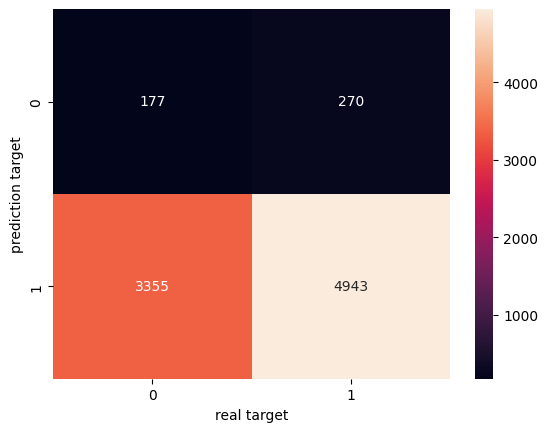

In [37]:
# vizualizacia
cm = confusion_matrix(test_target, prediction)
sns.heatmap(cm.T, annot=True, fmt='d')
plt.xlabel('real target'); plt.ylabel('prediction target');

V tomto obrázku môžeme vidieť, že model má problémy s klasifikovaním nulovej hodnoty.

In [111]:
# graphviz nefungoval, toto je prilis velky obrazok
#fig = plt.figure(figsize = (15, 20))
#_ = tree.plot_tree(dtf, feature_names = use_test_data.columns, class_names = ["1","0"], filled = True)
#fig.savefig("strom.png")

## 3. Optimalizácia alias hyperparameter tuning

Preskúmanie hyperparametrov

1. criterion je funkcia, ktorá meria kvalitu rozdelenia. Obsahuje hodnoty gini a entropy

2. splitter je stratégia rozdelenia, ktorá sa používa na všetkých uzloch stromu. využíva stratégie best a random.

3. max_depth je maximalna hĺbka stromu.

4. max_features charakterizuje počet stĺpcov, ktoré sa berú na vedomie pri hľadaní najlepšieho rozdelenia. Do max_depth a max_features sme vložili rozsah hodnôt.

In [67]:
parameters = {'criterion': ('gini','entropy'), 'splitter': ('best','random'), 'max_features':range(1,20,1)}
optimization = GridSearchCV(dtf, parameters,cv=3,scoring="accuracy")
result = optimization.fit(x_train_data, train_target)

Na vytvorenie modelu pre všetky kombinácie sme využili metódu GridSearchCV() 

In [68]:
params = optimization.best_params_
params

{'criterion': 'entropy', 'max_features': 5, 'splitter': 'best'}

In [69]:
tab = pd.DataFrame(optimization.cv_results_)
tab.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015625,0.000026,0.005205,0.007361,gini,1,best,"{'criterion': 'gini', 'max_features': 1, 'spli...",0.914096,0.904304,0.914449,0.910950,0.004701,70
1,0.007400,0.006422,0.000000,0.000000,gini,1,random,"{'criterion': 'gini', 'max_features': 1, 'spli...",0.864585,0.891188,0.860126,0.871966,0.013713,75
2,0.028943,0.003253,0.000000,0.000000,gini,2,best,"{'criterion': 'gini', 'max_features': 2, 'spli...",0.915943,0.912433,0.924427,0.917601,0.005035,66
3,0.010245,0.000007,0.000000,0.000000,gini,2,random,"{'criterion': 'gini', 'max_features': 2, 'spli...",0.887308,0.895991,0.912232,0.898511,0.010330,74
4,0.031402,0.001001,0.002703,0.003823,gini,3,best,"{'criterion': 'gini', 'max_features': 3, 'spli...",0.928321,0.925919,0.930340,0.928193,0.001807,44


In [70]:
opt = optimization.best_estimator_
opt

DecisionTreeClassifier(criterion='entropy', max_features=5)

In [71]:
clf = optimization.best_estimator_
clf = clf.fit(x_train_data,train_target)

predict=clf.predict(x_test_data)

In [72]:
print("score: ",metrics.accuracy_score(test_target,predict))

score:  0.5963407661520869


## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu 

**Výber atribútov**

Atribúty, ktoré používame v modeloch sme určili na základe AQI indexu a podľa korelácií zistených v predchádzajúcej fáze. Predpokladáme, že tieto atribúty sú najviac relevantné k dosiahnutiu výsledkov.

<font color="red">TODO zlepšuje scaling accuracy? </font>

**Stratégia riešenia chýbajúcich hodnôť a outlierov**

V predchádzajúcich fázach sme outliery odstránili, keďže by mohol model s ich použitím produkovať horšie predikcie a byť menej stabilný, s vyššou varianciou a preto tento krok považujeme za správny.

Chýbajúce hodnoty sme nahradili pomocou priemeru z jednotlivých stĺpcov, aby sme tým nezvyšovali varianciu modelu a mali presnejšie dáta.


In [30]:
train_target2 = train_data["warning"]
test_target2 = test_data["warning"]

x_train_data2 = train_data[['CH4', 'O3', 'PM2.5', 'SO2', 'longitude', 'latitude', 'C2H3NO5', 'CO', 'NH3', 'NOx']]
x_test_data2 = test_data[['CH4', 'O3', 'PM2.5', 'SO2', 'longitude', 'latitude', 'C2H3NO5', 'CO', 'NH3', 'NOx']]

**Hyperparameter tuning resp. ensemble learning**

In [73]:
rfc = RandomForestClassifier(random_state = 7, n_estimators = 300, max_depth = None, min_samples_split = 2,  min_samples_leaf = 2) 
model = rfc.fit(x_train_data2, train_target2) 
predicted_ens = model.predict(x_test_data2)

In [74]:
print("Accuracy RFC:",accuracy_score(test_target2, predicted_ens))

Accuracy RFC: 0.5961120640365923


In [75]:
print("Accuracy DTC: ",metrics.accuracy_score(test_target,predict))

Accuracy DTC:  0.5963407661520869


Random forest classifier v tomto prípade produkuje horšie lepšie výsledky než decision tree classifier. RFC väčšinou zvyšuje presnosť modelu pomocou výberu z viacerých náhodne generovaných stromov.